
# CoIL 2000 – Fase 1: Limpieza, EDA, Preprocesamiento + Diccionario de Datos
**Fuente de datos:** `/mnt/data/insurance_company_modified.csv`  
**Diccionario:** `/mnt/data/TicDataDescr.txt`

Este notebook implementa un flujo **reproducible** y **justificado** que:
1) Carga el CSV con un **mapa de valores nulos** robusto.  
2) Integra el **diccionario de datos** (convalidación de columnas) y lo guarda como `reports/data_dictionary.csv`.  
3) Normaliza formatos e **imputa** valores faltantes, con énfasis en **variables clave CoIL**.  
4) Realiza EDA con **matplotlib** (distribución, dispersión, correlación).  
5) Aplica tratamiento de **outliers** por IQR.  
6) Genera **features derivados** (*número × contribución*) al estilo Elkan.  
7) Incluye celdas para **integración con DVC** (versionado).


## Resumen Completo de Procedimientos

Este notebook ha implementado un flujo de procesamiento de datos para el dataset de la compañía de seguros, siguiendo los siguientes pasos:

1.  **Carga de Datos y Auditoría Inicial:** Se cargó el archivo CSV `insurance_company_modified.csv` de manera robusta, especificando una lista de tokens a considerar como valores nulos para asegurar una correcta interpretación de los datos faltantes. Se realizó una auditoría inicial imprimiendo las dimensiones del DataFrame, un resumen `info()` y el porcentaje de valores nulos por columna, destacando las 20 columnas con mayor cantidad de nulos.

2.  **Integración del Diccionario de Datos:** Se parseó el archivo `TicDataDescr.txt` para extraer la información del diccionario de datos (Número, Nombre, Descripción, Dominio). Esta información se estructuró en un DataFrame y se guardó como `reports/data_dictionary.csv`. Se validó la consistencia entre las columnas presentes en el CSV cargado y las documentadas en el diccionario, reportando las columnas faltantes o extra en cada caso.

3.  **Normalización de Formatos y Coerción a Numérico:** Se implementó una función `coerce_numeric` para limpiar y convertir a tipo numérico columnas que pudieran contener caracteres no numéricos (como comas o símbolos de porcentaje). Se identificaron columnas `object` que potencialmente contenían datos numéricos y se aplicó la coerción. Se normalizó el formato de las columnas de texto restantes (eliminando espacios extra). Se generó un reporte `coercion_report.json` detallando los cambios en el número de nulos tras la coerción.

4.  **Identificación de Variable Objetivo y Variables CoIL Prioritarias:** Se definieron explícitamente la variable objetivo (`CARAVAN`) y una lista de prefijos de columnas consideradas clave para el análisis CoIL. Se verificó la existencia de la variable objetivo y se listaron las columnas en el DataFrame que coinciden con los prefijos clave.

5.  **Imputación con Reglas de Negocio y Genéricas:** Se aplicaron reglas de imputación específicas para variables clave relacionadas con pólizas de autos y fuego, utilizando medianas condicionadas por el número de pólizas cuando fue posible. La moda se utilizó para imputar la variable de poder adquisitivo (`MKOOPKLA`). Para variables binarias (relacionadas con barco, social y terceros), se imputaron los valores faltantes con 0. Finalmente, se aplicó una imputación genérica: la mediana para columnas numéricas restantes y la moda para columnas categóricas restantes.

6.  **Tratamiento de Outliers (IQR Capping):** Se definió una función `iqr_cap` para limitar los valores atípicos utilizando el método del rango intercuartílico (IQR). Esta función se aplicó a todas las columnas numéricas para mitigar el impacto de valores extremos.

7.  **Análisis Exploratorio de Datos (EDA) con Matplotlib:** Se cargó el diccionario de datos guardado para enriquecer las visualizaciones con descripciones. Se generaron histogramas para visualizar la distribución de las variables numéricas. Se realizaron gráficos de dispersión para pares clave de variables (número vs. contribución para pólizas de auto y fuego). Se calculó y visualizó una matriz de correlación para las variables numéricas, y se imprimieron las top 10 correlaciones con la variable objetivo `CARAVAN`.

8.  **Generación de Features Derivados (Número × Contribución):** Siguiendo una metodología tipo Elkan, se crearon nuevas características cruzadas combinando el número y la contribución para las pólizas de auto y fuego. Se binaron las variables de número y contribución y se concatenaron sus categorías para formar nuevas variables categóricas cruzadas (`CAR_CROSS`, `FIRE_CROSS`).

9.  **Guardado del Dataset Limpio y Reporte de Calidad:** El DataFrame procesado (`data`) se guardó en un nuevo archivo CSV (`insurance_clean.csv`) en el directorio `data/processed`. Se generó y guardó un reporte de calidad en formato JSON (`reports/quality_report.json`) resumiendo las dimensiones del dataset limpio, el total de nulos, las columnas con nulos restantes y las rutas a los archivos de reporte y datos.

10. **Integración con DVC:** Se incluyeron comandos de shell comentados para inicializar DVC, agregar el dataset limpio (`insurance_clean.csv`) para versionado, definir una etapa `prepare` en `dvc.yaml` que simula la generación del archivo limpio a partir del original y un script de preparación (`src/prepare_data.py`). Estos comandos preparan el proyecto para el versionado y la gestión de datos con DVC.

Este flujo proporciona un punto de partida sólido para el modelado, asegurando datos limpios, estructurados y documentados, con trazabilidad inicial mediante DVC.

In [ ]:

# =============================
# 0. Librerías y configuración
# =============================
import os, json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer

pd.set_option("display.max_columns", None)

# Configuración de rutas locales para reports y data procesada
REPORTS_DIR = '../reports/'  # Relativo al notebook en Fase1_team42/notebooks/
PROCESSED_DATA_DIR = '../data/processed/'
RAW_PATH = '../data/insurance_company_modified.csv'
DICT_PATH = '../data/TicDataDescr_newname.txt'

os.makedirs(REPORTS_DIR, exist_ok=True)
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)



## 1) Carga de datos y **auditoría inicial**
- **Mapa de nulos** ampliado: captura entradas como `"NA"`, `"-"`, `"?"`, `" "`, `"None"`, etc.  
- Reporte de **dimensiones, `info()` y % de nulos** por columna.


In [ ]:
# =============================
# 1. Carga robusta del CSV
# =============================

#Marcelo: Comente la ruta para poderlo correr en mi google colab
#RAW_PATH = "/content/drive/MyDrive/Mlops_team42/data/insurance_company_modified.csv"  # archivo corregido
#DICT_PATH = "/content/drive/MyDrive/Mlops_team42/data/TicDataDescr_newname.txt"

#Ruta Marcelo
RAW_PATH = "/content/drive/MyDrive/Colab Notebooks/MNA/Mlops_team42/data/insurance_company_modified.csv"  # archivo corregido
DICT_PATH = "/content/drive/MyDrive/Colab Notebooks/MNA/Mlops_team42/data/TicDataDescr_newname.txt"


na_tokens = ["", " ", "NA", "N/A", "NULL", "null", "None", "-", "?", "—", "nan", "NaN"]
df = pd.read_csv(RAW_PATH, na_values=na_tokens, keep_default_na=True)

print("Dimensiones iniciales:", df.shape)
display(df.head(3))

from io import StringIO
buf = StringIO()
df.info(buf=buf)
print(buf.getvalue())

null_pct = (df.isna().mean() * 100).sort_values(ascending=False)
print("\nTop 20 columnas con mayor porcentaje de nulos (%):")
display(null_pct.head(20))

Dimensiones iniciales: (5937, 87)


,33,1,3,2,8,0,5,1.1,3.1,7,0.1,2.1,1.2,2.2,6,1.3,2.3,7.1,1.4,0.2,1.5,2.4,5.1,2.5,1.6,1.7,2.6,6.1,1.8,1.9,8.1,8.2,0.3,1.10,8.3,1.11,0.4,4,5.2,0.5,0.6,4.1,3.2,0.7,0.8,0.9,6.2,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,5.3,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,1.12,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,1.13,0.40,0.41,0.42,0.43,0.44,0.45,mixed_type_col
0,37.0,1.0,2.0,2.0,8.0,1.0,4.0,NaN,4.0,6.0,2.0,2.0,0.0,4.0,5.0,0.0,5.0,4.0,0.0,0.0,0.0,5.0,0.0,4.0,0.0,2.0,3.0,5.0,0.0,2.0,7.0,NaN,1.0,2.0,6.0,3.0,2.0,0.0,5.0,2.0,0.0,5.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,invalid,0.0,0.0,0.0,0.0,0.0,108
1,37.0,1.0,2.0,2.0,8.0,0.0,4.0,2.0,4.0,3.0,2.0,4.0,4.0,4.0,2.0,0.0,5.0,4.0,0.0,0.0,0.0,7.0,0.0,2.0,0.0,5.0,0.0,4.0,0.0,7.0,2.0,7.0,0.0,2.0,9.0,0.0,4.0,5.0,0.0,294.0,0.0,3.0,4.0,2.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown
2,9.0,1.0,3.0,3.0,3.0,2.0,3.0,2.0,4.0,5.0,2.0,2.0,2.0,3.0,4.0,3.0,4.0,2.0,4.0,0.0,0.0,3.0,1.0,2.0,3.0,2.0,1.0,4.0,0.0,5.0,4.0,9.0,0.0,0.0,7.0,2.0,1.0,5.0,3.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,480.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,904


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 87 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   33              5864 non-null   object
 1   1               5857 non-null   object
 2   3               5866 non-null   object
 3   2               5860 non-null   object
 4   8               5865 non-null   object
 5   0               5855 non-null   object
 6   5               5853 non-null   object
 7   1.1             5867 non-null   object
 8   3.1             5871 non-null   object
 9   7               5873 non-null   object
 10  0.1             5865 non-null   object
 11  2.1             5867 non-null   object
 12  1.2             5864 non-null   object
 13  2.2             5845 non-null   object
 14  6               5871 non-null   object
 15  1.3             5861 non-null   object
 16  2.3             5872 non-null   object
 17  7.1             5864 non-null   object
 18  1.4     

,0
mixed_type_col,9.988210
5.3,1.667509
2.2,1.549604
2.4,1.549604
0.19,1.549604
1.4,1.499074
0.6,1.482230
0.7,1.465387
1.5,1.448543
0.23,1.448543



## 2) **Integración del diccionario de datos** (TicDataDescr.txt)
Se parsea el diccionario, se construye un DataFrame con **Número, Nombre, Descripción y Dominio** y se valida contra el CSV cargado. Se guarda en `reports/data_dictionary.csv`.


In [ ]:
# =============================
# 2. Parseo tolerante del diccionario
# =============================
numbers, names, descriptions, domains, new_names = [], [], [], [], []

in_table = False
with open(DICT_PATH, "r", encoding="latin-1") as f:
    for raw in f:
        line = raw.strip()
        if not line:
            continue
        if line.startswith("DATADICTIONARY"):
            in_table = True
            continue
        if not in_table:
            continue
        if line.startswith("L0:"):
            break
        if line.startswith("Nr "):
            continue
        parts = line.split()
        if len(parts) >= 3 and parts[0].isdigit(): # Modified to expect 3 parts
            num = int(parts[0])
            name = parts[1]
            new_name = parts[2] # Added new_name
            rest = line[len(parts[0])+len(parts[1])+len(parts[2])+3:].strip() # Adjusted slice
            dom = ""
            desc = rest
            see_idx = rest.lower().rfind(" see ")
            if see_idx != -1:
                desc = rest[:see_idx].strip()
                dom = rest[see_idx+1:].strip()
            else:
                tokens = rest.split()
                dom_start = None
                for i, t in enumerate(tokens):
                    if re.search(r"(see|[0-9%–\-f])", t, flags=re.I):
                        dom_start = i
                        break
                if dom_start is not None:
                    desc = " ".join(tokens[:dom_start]).strip()
                    dom = " ".join(tokens[dom_start:]).strip()
            numbers.append(num)
            names.append(name)
            new_names.append(new_name) # Append new_name
            descriptions.append(desc)
            domains.append(dom)

data_dict = pd.DataFrame({
    "Column": numbers,
    "Name": names,
    "NewName": new_names, # Added NewName column
    "Description": descriptions,
    "Domain": domains
}).sort_values("Column")

# Guardar el diccionario de datos
DATA_DICT_PATH = os.path.join(REPORTS_DIR, 'data_dictionary.csv')
data_dict.to_csv(DATA_DICT_PATH, index=False, encoding="utf-8")
print("Diccionario cargado:", data_dict.shape)
display(data_dict.head(10))

# Use 'NewName' for validation
missing_in_csv = [c for c in data_dict["NewName"] if c not in df.columns]
extra_in_csv = [c for c in df.columns if c not in set(data_dict["NewName"])]
print("Columnas del diccionario NO presentes en el CSV:", len(missing_in_csv))
print(missing_in_csv[:20])
print("Columnas del CSV NO documentadas en diccionario:", len(extra_in_csv))
print(extra_in_csv[:20])

Diccionario cargado: (86, 5)


,Column,Name,NewName,Description,Domain
0,1,MOSTYPE,CSubType,Customer Subtype,see L0
1,2,MAANTHUI,NumHouse,Number,of houses 1 10
2,3,MGEMOMV,AvgSzHouse,Avg size household,1 6
3,4,MGEMLEEF,AvgAge,Avg age,see L1
4,5,MOSHOOFD,CMainType,Customer main type,see L2
5,6,MGODRK,DemCatholic,Roman catholic,see L3
6,7,MGODPR,DemProtestant,Protestant ...,
7,8,MGODOV,DemOthReligion,Other religion,
8,9,MGODGE,DemNoReligion,No religion,
9,10,MRELGE,DemMarried,Married,


Columnas del diccionario NO presentes en el CSV: 86
['CSubType', 'NumHouse', 'AvgSzHouse', 'AvgAge', 'CMainType', 'DemCatholic', 'DemProtestant', 'DemOthReligion', 'DemNoReligion', 'DemMarried', 'DemCohabitation', 'DemOtherRelation', 'DemSingles', 'DemNoChild', 'DemWithChild', 'DemHiLeEdu', 'DemMiLeEdu', 'DemLoLeEdu', 'DemHiStatus', 'DemEntrepreneur']
Columnas del CSV NO documentadas en diccionario: 87
['33', '1', '3', '2', '8', '0', '5', '1.1', '3.1', '7', '0.1', '2.1', '1.2', '2.2', '6', '1.3', '2.3', '7.1', '1.4', '0.2']



## 3) **Normalización de formatos** e imputación orientada a **datos en formato incorrecto**
Primero **coerción a numérico** (limpieza de comas, `%`, símbolos), luego **imputación**.


In [ ]:

# =============================
# 3. Coerción y normalización
# =============================
def coerce_numeric(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.replace(",", "", regex=False)
    s = s.str.replace("%", "", regex=False)
    s = s.str.replace(r"[^\d\.\-]", "", regex=True)
    return pd.to_numeric(s, errors="coerce")

obj_cols = df.select_dtypes(include=["object"]).columns.tolist()
maybe_numeric = []
for col in obj_cols:
    sample = df[col].dropna().astype(str).head(50)
    if sample.empty:
        continue
    looks_numeric = sample.str.replace(r"[,\s%]", "", regex=True).str.match(r"^-?\d+(\.\d+)?$").mean()
    if looks_numeric > 0.6:
        maybe_numeric.append(col)

coerce_report = {}
for col in maybe_numeric:
    before_na = df[col].isna().sum()
    coerced = coerce_numeric(df[col])
    after_na = coerced.isna().sum()
    df[col] = coerced
    coerce_report[col] = {"n_null_before": int(before_na), "n_null_after": int(after_na)}

def normalize_text(s: pd.Series) -> pd.Series:
    return s.astype(str).str.strip().str.replace(r"\s+", " ", regex=True)

for col in obj_cols:
    if col not in maybe_numeric:
        df[col] = normalize_text(df[col])

import json
# Guardar el reporte de coerción
COERCION_REPORT_PATH = os.path.join(REPORTS_DIR, 'coercion_report.json')
with open(COERCION_REPORT_PATH, "w", encoding="utf-8") as f:
    json.dump(coerce_report, f, indent=2, ensure_ascii=False)

print("Coerción numérica y normalización de texto completadas.")


Coerción numérica y normalización de texto completadas.



## 4) Variable objetivo y **variables CoIL prioritarias**


In [ ]:

TARGET = "CARAVAN"
KEY_COLS = [
    "PPERSAUT", "APERSAUT",
    "PBRAND", "ABRAND",
    "MKOOPKLA",
    "PPLEZIER", "APLEZIER",
    "PBYSTAND", "ABYSTAND",
    "PWAPART", "AWAPART"
]
print("¿Existe CARAVAN?:", TARGET in df.columns)
key_like = [c for c in df.columns if any(c.startswith(pfx) for pfx in KEY_COLS)]
print("Columnas con prefijos clave CoIL:", len(key_like))
key_like[:20]


¿Existe CARAVAN?: False
Columnas con prefijos clave CoIL: 0


[]


## 5) **Imputación** con reglas de negocio + genéricas


In [ ]:

data = df.copy()

# Autos
num_col = "APERSAUT_Number_of_car_policies" if "APERSAUT_Number_of_car_policies" in data.columns else "APERSAUT"
contrib_col = "PPERSAUT_Contribution_car_policies" if "PPERSAUT_Contribution_car_policies" in data.columns else "PPERSAUT"

if num_col in data.columns and contrib_col in data.columns:
    mask = data[num_col].isna() & (data[contrib_col].fillna(0) > 0)
    data.loc[mask, num_col] = 1
    cond_mask = data[contrib_col].isna() & (data[num_col].fillna(0) > 0)
    if cond_mask.any():
        try:
            med_by_n = data.groupby(num_col)[contrib_col].median()
            data.loc[cond_mask, contrib_col] = data.loc[cond_mask, num_col].map(med_by_n)
        except Exception:
            data.loc[cond_mask, contrib_col] = data[contrib_col].median()

# Fuego
fnum_col = "ABRAND_Number_of_fire_policies" if "ABRAND_Number_of_fire_policies" in data.columns else "ABRAND"
fcontrib_col = "PBRAND_Contribution_fire_policies" if "PBRAND_Contribution_fire_policies" in data.columns else "PBRAND"

if fnum_col in data.columns and fcontrib_col in data.columns:
    mask = data[fnum_col].isna() & (data[fcontrib_col].fillna(0) > 0)
    data.loc[mask, fnum_col] = 1
    cond_mask = data[fcontrib_col].isna() & (data[fnum_col].fillna(0) > 0)
    if cond_mask.any():
        try:
            med_by_n = data.groupby(fnum_col)[fcontrib_col].median()
            data.loc[cond_mask, fcontrib_col] = data.loc[cond_mask, fnum_col].map(med_by_n)
        except Exception:
            data.loc[cond_mask, fcontrib_col] = data[fcontrib_col].median()

# Poder adquisitivo -> moda
pp_col = "MKOOPKLA_Purchasing_power_class" if "MKOOPKLA_Purchasing_power_class" in data.columns else "MKOOPKLA"
if pp_col in data.columns and data[pp_col].isna().any():
    mode_val = data[pp_col].mode(dropna=True)
    if not mode_val.empty:
        data[pp_col].fillna(mode_val.iloc[0], inplace=True)

# Binarios (barco, social, third party) -> 0
bin_candidates = [c for c in data.columns if re.search(r"(PLEZIER|APLEZIER|BYSTAND|ABYSTAND|WAPART|AWAPART)", c, re.I)]
for col in bin_candidates:
    if data[col].dtype.kind in "biufc":
        data[col] = data[col].fillna(0)
    else:
        data[col] = data[col].str.lower().map({"yes":1,"no":0})
        data[col] = data[col].fillna(0)

# Genérico
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = data.select_dtypes(exclude=[np.number]).columns.tolist()

if num_cols:
    data[num_cols] = SimpleImputer(strategy="median").fit_transform(data[num_cols])
if cat_cols:
    data[cat_cols] = SimpleImputer(strategy="most_frequent").fit_transform(data[cat_cols])

print("Imputación completada.")


Imputación completada.



## 6) Tratamiento de **outliers** (IQR capping)


In [ ]:

def iqr_cap(series, factor=1.5):
    q1, q3 = series.quantile(0.25), series.quantile(0.75)
    iqr = q3 - q1
    low, high = q1 - factor*iqr, q3 + factor*iqr
    return series.clip(lower=low, upper=high)

for col in num_cols:
    data[col] = iqr_cap(data[col])

print("Outliers cappeados por IQR.")


Outliers cappeados por IQR.


## Redondeo de valores numéricos
Se redondean los valores numéricos a la unidad más cercana para convertirlos a enteros.

In [ ]:
# =============================
# Redondeo de valores numéricos a entero
# =============================
num_cols_after_processing = data.select_dtypes(include=[np.number]).columns.tolist()

for col in num_cols_after_processing:
    # Se redondea y se convierte a integer, manejando NaNs si los hubiera (aunque imputamos, es buena práctica)
    # fillna(0) es un workaround para convertir a int, ya que pd.NA aún no soporta astype(int) directamente
    data[col] = data[col].round().fillna(0).astype(int)

print("Valores numéricos redondeados a enteros.")

Valores numéricos redondeados a enteros.



## 7) EDA: distribución, dispersión y correlación (matplotlib)


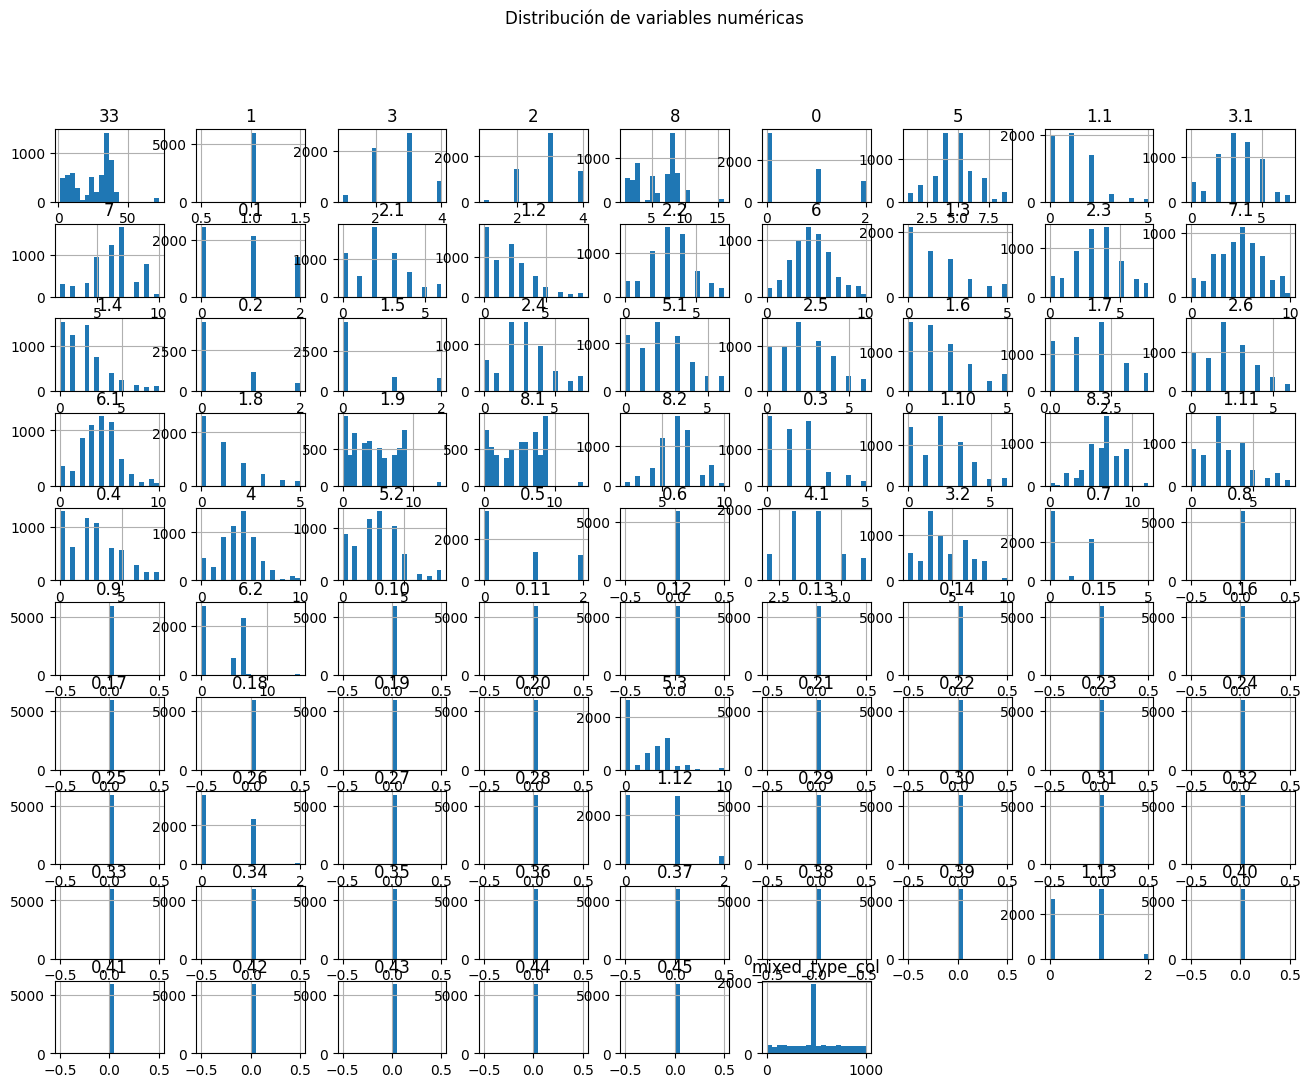

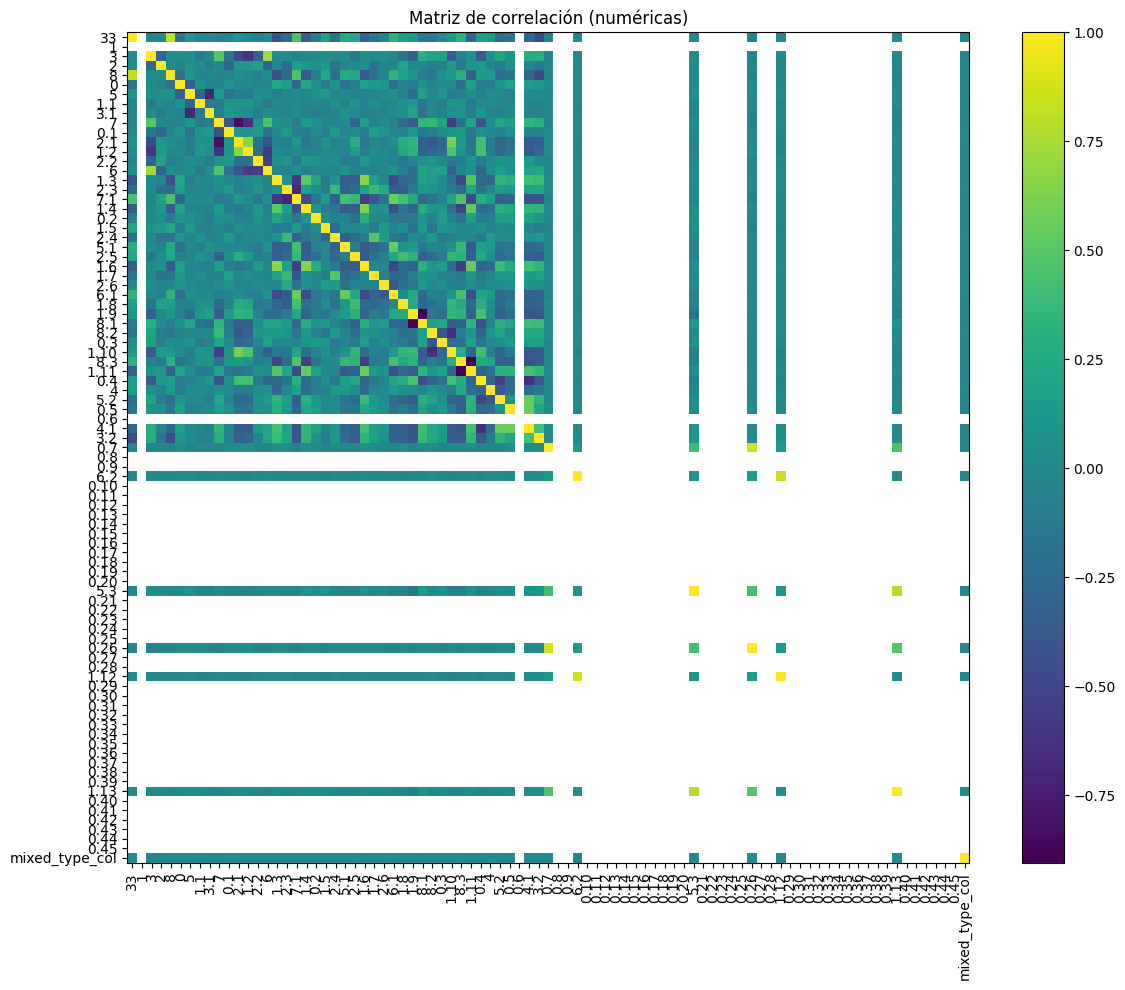

In [ ]:

# Cargar diccionario guardado para lookup de descripciones

#Marcelo: RUta modificada de nuevo
#data_dict = pd.read_csv("/content/drive/MyDrive/Mlops_team42/reports/data_dictionary.csv")

#Ruta Marcelo:
data_dict = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MNA/Mlops_team42/reports/data_dictionary.csv")

def describe_var(col):
    row = data_dict.loc[data_dict["Name"] == col]
    if not row.empty:
        return f"{col}: {row['Description'].values[0]} (Domain: {row['Domain'].values[0]})"
    return col

# Guardar figuras del EDA en la carpeta de reports
if num_cols:
    ax = data[num_cols].hist(bins=20, figsize=(16, 12))
    plt.suptitle("Distribución de variables numéricas")
    plt.savefig(os.path.join(REPORTS_DIR, 'histogramas_numericas.png'))
    plt.close()

# Dispersión pares clave
pairs = [
    ("APERSAUT_Number_of_car_policies" if "APERSAUT_Number_of_car_policies" in data.columns else "APERSAUT",
     "PPERSAUT_Contribution_car_policies" if "PPERSAUT_Contribution_car_policies" in data.columns else "PPERSAUT"),
    ("ABRAND_Number_of_fire_policies" if "ABRAND_Number_of_fire_policies" in data.columns else "ABRAND",
     "PBRAND_Contribution_fire_policies" if "PBRAND_Contribution_fire_policies" in data.columns else "PBRAND")
]
for x, y in pairs:
    if x in data.columns and y in data.columns:
        plt.figure(figsize=(6,4))
        plt.scatter(data[x], data[y], alpha=0.3)
        plt.xlabel(describe_var(x))
        plt.ylabel(describe_var(y))
        plt.title(f"Dispersión: {x} vs {y}")
        plt.savefig(os.path.join(REPORTS_DIR, f'scatter_{x}_vs_{y}.png'))
        plt.close()

# Matriz de correlación
if len(num_cols) > 1:
    corr = data[num_cols].corr()
    plt.figure(figsize=(12, 10))
    plt.imshow(corr, cmap="viridis", aspect="auto")
    plt.colorbar()
    plt.title("Matriz de correlación (numéricas)")
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.tight_layout()
    plt.savefig(os.path.join(REPORTS_DIR, 'matriz_correlacion.png'))
    plt.close()
    if "CARAVAN" in data.columns and "CARAVAN" in corr.columns:
        print("Top 10 correlaciones con CARAVAN:")
        print(corr["CARAVAN"].sort_values(ascending=False).head(10))



## 8) **Features derivados** (*número × contribución*) (Elkan)


In [ ]:

def make_bins(series, bins=(0, 1, 100, 500, 1000, 999999), labels=None):
    if labels is None:
        labels = [f"L{i}" for i in range(1, len(bins))]
    return pd.cut(series, bins=bins, labels=labels, include_lowest=True, right=False)

# Autos
xnum = "APERSAUT_Number_of_car_policies" if "APERSAUT_Number_of_car_policies" in data.columns else "APERSAUT"
xcon = "PPERSAUT_Contribution_car_policies" if "PPERSAUT_Contribution_car_policies" in data.columns else "PPERSAUT"
if xnum in data.columns and xcon in data.columns:
    data["CAR_NUM_bin"] = pd.to_numeric(data[xnum], errors="coerce").fillna(0).astype(int)
    data["CAR_CONTR_bin"] = make_bins(pd.to_numeric(data[xcon], errors="coerce").fillna(0))
    data["CAR_CROSS"] = data["CAR_NUM_bin"].astype(str) + "_" + data["CAR_CONTR_bin"].astype(str)

# Fuego
fnum = "ABRAND_Number_of_fire_policies" if "ABRAND_Number_of_fire_policies" in data.columns else "ABRAND"
fcon = "PBRAND_Contribution_fire_policies" if "PBRAND_Contribution_fire_policies" in data.columns else "PBRAND"
if fnum in data.columns and fcon in data.columns:
    data["FIRE_NUM_bin"] = pd.to_numeric(data[fnum], errors="coerce").fillna(0).astype(int)
    data["FIRE_CONTR_bin"] = make_bins(pd.to_numeric(data[fcon], errors="coerce").fillna(0))
    data["FIRE_CROSS"] = data["FIRE_NUM_bin"].astype(str) + "_" + data["FIRE_CONTR_bin"].astype(str)

print("Features cruzados generados (si aplican).")


Features cruzados generados (si aplican).



## 9) Guardado del dataset limpio + **reporte de calidad**


In [ ]:
# =============================
# 9. Guardado del dataset limpio + reporte de calidad
# =============================

# Guardar el dataset limpio y el reporte de calidad en la ruta local
OUT_PATH = os.path.join(PROCESSED_DATA_DIR, 'insurance_clean.csv')

# Rename columns using the data dictionary's 'NewName'
# Ensure the dictionary is loaded and contains the 'NewName' column
if 'data_dict' in locals() and not data_dict.empty and 'NewName' in data_dict.columns:
    # Create a dictionary mapping old column names to new column names
    # Assuming the order of columns in data_dict matches the order in data
    # It's safer to map based on the original column names if they were preserved
    # Since the original column names are the numerical ones, we'll use those for mapping
    # and assume they correspond to the order in data_dict
    # Let's verify this assumption by looking at the 'Column' in data_dict and the original df columns
    # If the original df column names are the numbers from the dictionary, we can map directly.
    # Based on the previous cells, the original column names are the numbers as strings.
    # We need to map the original numerical string column names to the 'NewName'
    original_cols_in_df = df.columns[:-1] # Exclude the 'mixed_type_col' as it's not in the dictionary
    new_names_from_dict = data_dict['NewName'].tolist()

    # Check if the number of columns to rename matches
    if len(original_cols_in_df) == len(new_names_from_dict):
        rename_map = dict(zip(original_cols_in_df, new_names_from_dict))
        # Rename columns in the processed data DataFrame
        data = data.rename(columns=rename_map)
        print("Columns renamed using the data dictionary.")
    else:
        print("Warning: Number of columns in DataFrame does not match dictionary entries for renaming.")
        print(f"DataFrame columns (excluding last): {len(original_cols_in_df)}, Dictionary entries: {len(new_names_from_dict)}")


# Drop the last column
if data.shape[1] > len(data_dict):
    data = data.iloc[:, :-1]
    print("Last column dropped to match dictionary size.")
elif data.shape[1] < len(data_dict):
     print("Warning: Number of columns in DataFrame is less than dictionary entries after potential renaming.")


data.to_csv(OUT_PATH, index=False)

quality_report = {
    "n_rows": int(data.shape[0]),
    "n_cols": int(data.shape[1]),
    "total_nulls": int(data.isna().sum().sum()),
    "cols_with_nulls": {k:int(v) for k,v in data.isna().sum().items() if v>0},
    "coercion_report_path": os.path.relpath(COERCION_REPORT_PATH, start=os.path.dirname(__file__)) if '__file__' in globals() else COERCION_REPORT_PATH,
    "data_dictionary_path": os.path.relpath(DATA_DICT_PATH, start=os.path.dirname(__file__)) if '__file__' in globals() else DATA_DICT_PATH,
    "input_file": RAW_PATH,
    "output_file": OUT_PATH
}
QUALITY_REPORT_PATH = os.path.join(REPORTS_DIR, 'quality_report.json')
with open(QUALITY_REPORT_PATH, "w", encoding="utf-8") as f:
    json.dump(quality_report, f, indent=2, ensure_ascii=False)

print(f"Dataset limpio guardado en: {OUT_PATH}")
print(f"Reporte de calidad en: {QUALITY_REPORT_PATH}")

Columns renamed using the data dictionary.
Last column dropped to match dictionary size.
Dataset limpio guardado en: /content/drive/MyDrive/Colab Notebooks/MNA/Mlops_team42/data/processed/insurance_clean.csv
Reporte de calidad en: reports/quality_report.json



## 10) **Integración con DVC**


In [ ]:

# %%bash
# set -e
# if [ ! -d ".dvc" ]; then
#   dvc init
# fi
# dvc add data/processed/insurance_clean.csv
# git add data/processed/insurance_clean.csv.dvc .gitignore
# git commit -m "Add processed insurance_clean.csv with DVC and data dictionary"
#
# cat > dvc.yaml <<'YAML'
# stages:
#   prepare:
#     cmd: python src/prepare_data.py
#     deps:
#       - /mnt/data/insurance_company_modified.csv
#       - src/prepare_data.py
#     outs:
#       - data/processed/insurance_clean.csv
# YAML
# git add dvc.yaml
# git commit -m "Define 'prepare' DVC stage"
#
# # dvc remote add -d myremote s3://<tu-bucket>/coil-mlops
# # dvc push
# echo "DVC listo. Configura remoto y ejecuta 'dvc push' cuando corresponda."



## 11) Resumen
- **Diccionario** integrado y validado.  
- **Coerción + imputación** alineada a variables CoIL.  
- **Outliers** tratados.  
- **EDA** con matplotlib.  
- **Features** cruzados.  
- **DVC** preparado.
